In [1]:
import datetime
import matplotlib.pyplot as plt
import pyaurorax

aurorax = pyaurorax.PyAuroraX()

# TREx-ATM Forward Calculation

TREx-ATM is a time-dependent Aurora Transport Model (ATM), designed to leverage and support TREx optical data. TREx-ATM uses the two-stream electron transport code embedded in the GLOW model (Solomon et al., 1988) with ambipolar diffusion to compute the electron transport. It has additional capacity to compute impact ionization, secondary electron production, and impact excitation of neutrals (height resolved). Use of the TREx-ATM model should cite:

- Liang, J., Donovan, E., Jackel, B., Spanswick, E., & Gillies, M. (2016). On the 630nmred-linepulsating aurora: Red-line emission geospace observatory observations and model simulations. Journal of Geophysical Research: Space Physics, 121, 7988–8012. https://doi.org/10.1002/2016JA022901 
- Liang, J., Yang, B., Donovan, E., Burchill, J., & Knudsen, D. (2017). Ionospheric electron heating associated with pulsating auroras: A Swarm survey and model simulation. Journal of Geophysical Research: Space Physics, 122, 8781–8807. https://doi.org/10.1002/2017JA024127

## Perform a basic 'forward' calculation

First will show how to do a basic request, and plot the results.

Requests take a series of input parameters. Some parameters are required, and some are optional with default values that will be set if they are not supplied. The following request we'll be performing utilizes all default values for the optional parameter (marked as such with a comment on that line).

More details on inputs and outputs [in the `forward()` function documentation](https://docs.aurorax.space/code/pyaurorax_api_reference/pyaurorax/models/atm/index.html#pyaurorax.models.atm.ATMManager.forward).

<small>
Input notes:

- latitude and longitude are to be in geodetic coordinates (-90 to 90 lat, -180 to 180 lon)
- maxwellian_characteristic_energy must be specified if the maxwellian_energy_flux is not 0
- gaussian_peak_energy must be specified if the gaussian_energy_flux is not 0
- gaussian_spectral_width must be specified if the gaussian_energy_flux is not 0
- valid values for nrlmsis_model_version are '00' and '2.0'
- units
  - timescale parameters: seconds
  - maxwellian energy flux: erg/cm2/s
  - maxwellian characteristic energy: eV
  - gaussian energy flux: erg/cm2/s
  - gaussian peak energy: eV
  - gaussian spectral width: eV
  - custom spectrum
    - energy in eV, flux in 1/cm2/sr/eV
    - energy and flux arrays must be the same length
</small>

<small>
Output notes:

- output parameter of the request are toggles the enable/disable each field's inclusion in the response
- all output parameters are false by default
- altitude is in kilometers
- emission data: 1-D array -- volume emission rate (1/cm^3/s)
- plasma electron density: 1-D array -- density (cm^-3)
- plasma O2+ density: 1-D array -- density (cm^-3)
- plasma NO+ density: 1-D array -- density (cm^-3)
- plasma O+ density: 1-D array -- density (cm^-3)
- plasma ionisation rate: 1-D array -- ionisation rate (1/cm^3/s)
- plasma electron temperature: 1-D array -- temperature (K)
- plasma ion temperature: 1-D array -- temperature (K)
- plasma peterson conductivity: 1-D array -- conductivity (S/m)
- plasma hall conductivity: 1-D array -- conductivity (S/m)
- neutral O2 density: 1-D array -- density (cm^-3)
- neutral O density: 1-D array -- density (cm^-3)
- neutral N2 density: 1-D array -- density (cm^-3)
- neutral N density: 1-D array -- density (cm^-3)
- neutral temperature: 1-D array -- temperature (K)
</small>

ATM requests require that users toggle ON outputs they wish to have returned. This allows you to get back only what you want. This mechanism is controlled by the `ATMForwardOutputFlags()` class that must be instantiated before making an ATM calculation.

As part of this class, there are helper functions that toggle ON or OFF all outputs, and toggle on common groups.

In [2]:
# set up our request
#
# all output parameters are default to False. Here we initialize 
# the output flags we want to get
output = pyaurorax.models.ATMForwardOutputFlags()  # initialize output flags, all will be False by default
output.enable_only_height_integrated_rayleighs()   # enable all height-integrated Rayleighs values
output.altitudes = True                            # enable altitudes
output.emission_5577 = True                        # enable the 5577nm emission

# set the location (Calgary-ish)
#
# NOTE: ATM forward calculations can be performed 
# for any latitude or longitude
latitude = 51.04
longitude = -114.5

# set the timestamp to UT06 of the previous day
#
# NOTE: ATM forward calculations can be performed for any date up 
# to the end of the previous day. It is expected to be in UTC time, 
# and any timezone data will be ignored. 
timestamp = datetime.datetime.now().replace(hour=6, minute=0, second=0, microsecond=0) - datetime.timedelta(days=1)

In [ ]:
# perform the calculation
result = aurorax.models.atm.forward(timestamp, latitude, longitude, output)

# view the output
# 
# we use handy print method for the results
result.pretty_print()

ATMForwardResult:
  altitudes                            : array([ 80. ,  81. ,  82. ,  83. ,  84. ,  85. ,  86. ,  87. ...])
  emission_1304                        : None
  emission_1356                        : None
  emission_4278                        : None
  emission_5577                        : array([2.11235747e-04, 1.79183786e-03, 2.34156642e-02, 2.915 ...])
  emission_6300                        : None
  emission_8446                        : None
  emission_lbh                         : None
  height_integrated_rayleighs_1304     : 2700.116191
  height_integrated_rayleighs_1356     : 462.867496
  height_integrated_rayleighs_4278     : 2434.812700
  height_integrated_rayleighs_5577     : 19108.154875
  height_integrated_rayleighs_6300     : 328.036390
  height_integrated_rayleighs_8446     : 996.893576
  height_integrated_rayleighs_lbh      : 14861.280879
  neutral_n2_density                   : None
  neutral_n_density                    : None
  neutral_o2_density        

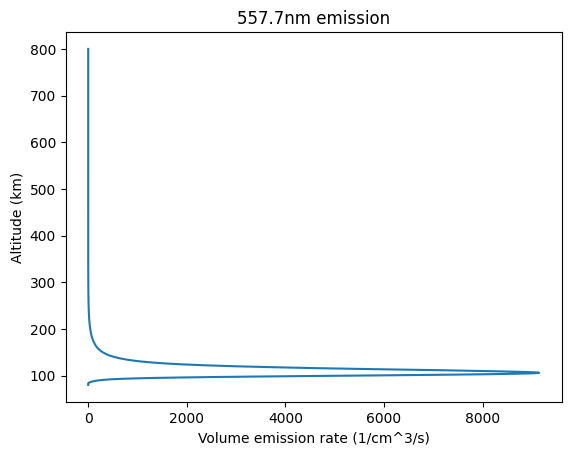

In [4]:
# plot the 557.7nm emission data
plt.title("557.7nm emission")
plt.xlabel("Volume emission rate (1/cm^3/s)")
plt.ylabel("Altitude (km)")
plt.plot(result.emission_5577, result.altitudes)
plt.show()

## Forward calculation and include all output parameters

You can also do a request and specify the output flags to return everything that the ATM 'forward' endpoint has to offer. Below, we're going to do that and plot all data.

In [5]:
# set up params
timestamp = datetime.datetime(2021, 11, 4, 6, 0, 0)
latitude = 58.227808
longitude = -103.680631

# set output flags
output = pyaurorax.models.ATMForwardOutputFlags()
output.set_all_true()

# run model
result = aurorax.models.atm.forward(timestamp, latitude, longitude, output)

# show results
result.pretty_print()

ATMForwardResult:
  altitudes                            : array([ 80. ,  81. ,  82. ,  83. ,  84. ,  85. ,  86. ,  87. ...])
  emission_1304                        : array([4.11610381e-06, 8.14978193e-06, 8.05713353e-05, 6.028 ...])
  emission_1356                        : array([6.52554263e-07, 1.36533311e-06, 1.35077644e-05, 1.010 ...])
  emission_4278                        : array([3.60688828e-02, 2.65546776e-02, 9.94128808e-02, 2.800 ...])
  emission_5577                        : array([1.80896735e-04, 1.10981788e-03, 1.33012030e-02, 1.544 ...])
  emission_6300                        : array([4.59566081e-07, 4.37480310e-07, 1.82652548e-06, 6.447 ...])
  emission_8446                        : array([1.50578353e-06, 3.01059140e-06, 2.97776405e-05, 2.228 ...])
  emission_lbh                         : array([1.90615952e-01, 1.61396325e-01, 6.04281723e-01, 1.702 ...])
  height_integrated_rayleighs_1304     : 1351.555829
  height_integrated_rayleighs_1356     : 230.423791
  height_inte

Height-integrated Rayleighs:
  427.8nm:  2501.37 R
  557.7nm:  15480.96 R
  630.0nm:  250.75 R
  844.6nm:  501.96 R
  LBH:      15266.78 R
  130.4nm:  1351.56 R
  135.6nm:  230.42 R


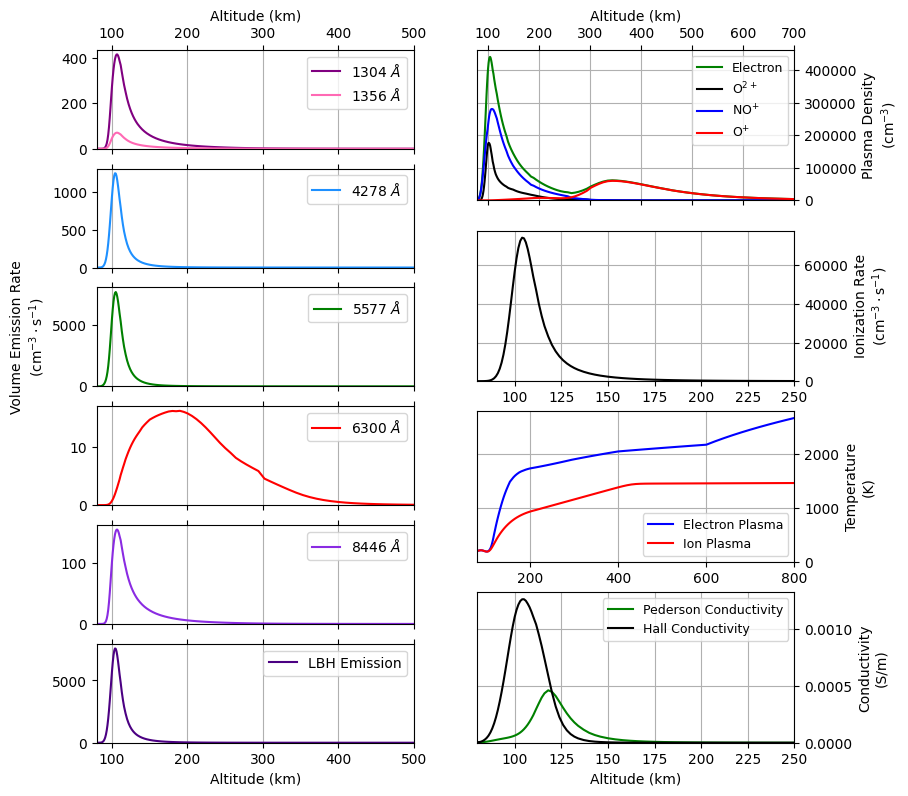

In [6]:
# now let's have a closer look at everything we got back
#
# print all height-integrated Rayleighs data
print("""Height-integrated Rayleighs:
  427.8nm:  %.02f R
  557.7nm:  %.02f R
  630.0nm:  %.02f R
  844.6nm:  %.02f R
  LBH:      %.02f R
  130.4nm:  %.02f R
  135.6nm:  %.02f R""" % (result.height_integrated_rayleighs_4278,
                          result.height_integrated_rayleighs_5577,
                          result.height_integrated_rayleighs_6300,
                          result.height_integrated_rayleighs_8446,
                          result.height_integrated_rayleighs_lbh,
                          result.height_integrated_rayleighs_1304,
                          result.height_integrated_rayleighs_1356))

# plot the emission, plasma, and neutral data
#
# we'll do this all in one plot, but made up from many subplots
alt = result.altitudes
fig = plt.figure(figsize=(9,9))

# plot all the emissions as a column of subplots
# 
# 1304 A & 1356 A emission
ax1 = fig.add_subplot(6,2,1)
ax1.plot(alt, result.emission_1304, label=r"1304 $\AA$", color="purple")
ax1.plot(alt, result.emission_1356, label=r"1356 $\AA$", color="hotpink")
ax1.legend()
ax1.set_xlim(80,500)
ax1.set_ylim(bottom=0)
ax1.grid(axis="x")
ax1.set_xlabel("Altitude (km)", va="bottom")
ax1.tick_params(axis="x", bottom=True, top=True, labeltop=True, labelbottom=False)
ax1.xaxis.set_label_position("top")

# blueline emission
ax2 = fig.add_subplot(6,2,3)
ax2.plot(alt, result.emission_4278, label=r"4278 $\AA$", color="dodgerblue")
ax2.legend()
ax2.set_xlim(80,500)
ax2.set_ylim(bottom=0)
ax2.grid(axis="x")
ax2.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# greenline emission
ax3 = fig.add_subplot(6,2,5)
ax3.plot(alt, result.emission_5577, label=r"5577 $\AA$", color="green")
ax3.legend()
ax3.set_xlim(80,500)
ax3.set_ylim(bottom=0)
ax3.grid(axis="x")
ax3.set_ylabel("Volume Emission Rate\n(cm$^{-3} \cdot $s$^{-1}$)")
ax3.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# redline emission
ax4 = fig.add_subplot(6,2,7)
ax4.plot(alt, result.emission_6300, label=r"6300 $\AA$", color="red")
ax4.legend()
ax4.set_xlim(80,500)
ax4.set_ylim(bottom=0)
ax4.grid(axis="x")
ax4.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# near-infrared 8446 A emission
ax5 = fig.add_subplot(6,2,9)
ax5.plot(alt, result.emission_8446, label=r"8446 $\AA$", color="blueviolet")
ax5.legend()
ax5.set_xlim(80,500)
ax5.set_ylim(bottom=0)
ax5.grid(axis="x")
ax5.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# Lyman-Birge-Hopfield emission
ax6 = fig.add_subplot(6,2,11)
ax6.plot(alt, result.emission_lbh, label="LBH Emission", color="indigo")
ax6.legend()
ax6.set_xlim(80,500)
ax6.set_ylim(bottom=0)
ax6.grid(axis="x")
ax6.set_xlabel("Altitude (km)")
ax6.tick_params(axis="x", bottom=True, top=True)

# plot the plasma data as a second column of subplots
#
# plasma density
ax7 = fig.add_subplot(4,2,2)
ax7.plot(alt, result.plasma_electron_density, label="Electron", color="green")
ax7.plot(alt, result.plasma_o2plus_density, label="O$^{2+}$", color="black")
ax7.plot(alt, result.plasma_noplus_density, label="NO$^{+}$", color="blue")
ax7.plot(alt, result.plasma_oplus_density, label="O$^{+}$", color="red")
ax7.grid()
ax7.set_ylabel("Plasma Density\n(cm$^{-3}$)")
ax7.legend(fontsize=9)
ax7.set_xlim(80,700)
ax7.set_ylim(bottom=0)
ax7.tick_params(axis="x", bottom=True, top=True, labeltop=True, labelbottom=False)
ax7.set_xlabel("Altitude (km)")
ax7.xaxis.set_label_position("top")
ax7.yaxis.set_label_position("right")
ax7.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# plasma ionisation rate
ax8 = fig.add_subplot(4,2,4)
ax8.plot(alt, result.plasma_ionisation_rate, color="black")
ax8.grid()
ax8.set_ylabel("Ionization Rate\n(cm$^{-3} \cdot $s$^{-1}$)")
ax8.set_xlim(80,250)
ax8.set_ylim(bottom=0)
ax8.yaxis.set_label_position("right")
ax8.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# plasma temperatures
ax9 = fig.add_subplot(4,2,6)
ax9.plot(alt, result.plasma_electron_temperature, label="Electron Plasma", color="blue")
ax9.plot(alt, result.plasma_ion_temperature, label="Ion Plasma", color="red")
ax9.grid()
ax9.legend(fontsize=9)
ax9.set_ylabel("Temperature\n(K)")
ax9.set_xlim(80,800)
ax9.set_ylim(bottom=0)
ax9.yaxis.set_label_position("right")
ax9.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# plasma conductivities
ax10 = fig.add_subplot(4,2,8)
ax10.plot(alt, result.plasma_pederson_conductivity, label="Pederson Conductivity", color="green")
ax10.plot(alt, result.plasma_hall_conductivity, label="Hall Conductivity", color="black")
ax10.grid()
ax10.legend(fontsize=9)
ax10.set_ylabel("Conductivity\n(S/m)")
ax10.set_xlim(80,250)
ax10.set_ylim(bottom=0)
ax10.set_xlabel("Altitude (km)")
ax10.yaxis.set_label_position("right")
ax10.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# render the plot
plt.show()